Best hyperparameters found by GridSearchCV:
{'C': 10.0, 'max_iter': 1000, 'multi_class': 'multinomial', 'solver': 'lbfgs'}
Train set accuracy: 92.65%


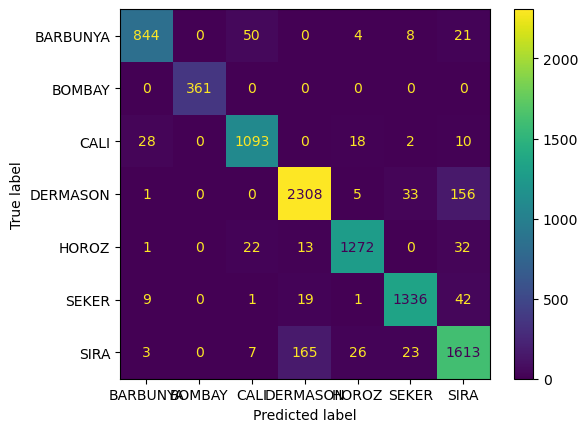

Classification report for train set:
              precision    recall  f1-score   support

    BARBUNYA       0.95      0.91      0.93       927
      BOMBAY       1.00      1.00      1.00       361
        CALI       0.93      0.95      0.94      1151
    DERMASON       0.92      0.92      0.92      2503
       HOROZ       0.96      0.95      0.95      1340
       SEKER       0.95      0.95      0.95      1408
        SIRA       0.86      0.88      0.87      1837

    accuracy                           0.93      9527
   macro avg       0.94      0.94      0.94      9527
weighted avg       0.93      0.93      0.93      9527



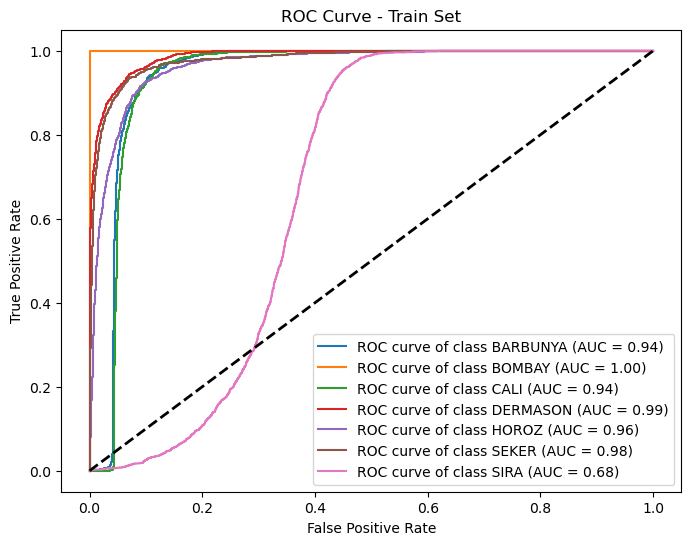

Average AUC (train set): 0.9273
Test set accuracy: 92.21%


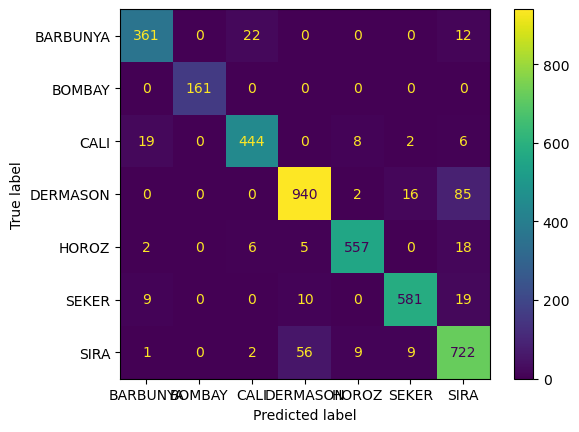

Classification report for test set:
              precision    recall  f1-score   support

    BARBUNYA       0.92      0.91      0.92       395
      BOMBAY       1.00      1.00      1.00       161
        CALI       0.94      0.93      0.93       479
    DERMASON       0.93      0.90      0.92      1043
       HOROZ       0.97      0.95      0.96       588
       SEKER       0.96      0.94      0.95       619
        SIRA       0.84      0.90      0.87       799

    accuracy                           0.92      4084
   macro avg       0.94      0.93      0.93      4084
weighted avg       0.92      0.92      0.92      4084



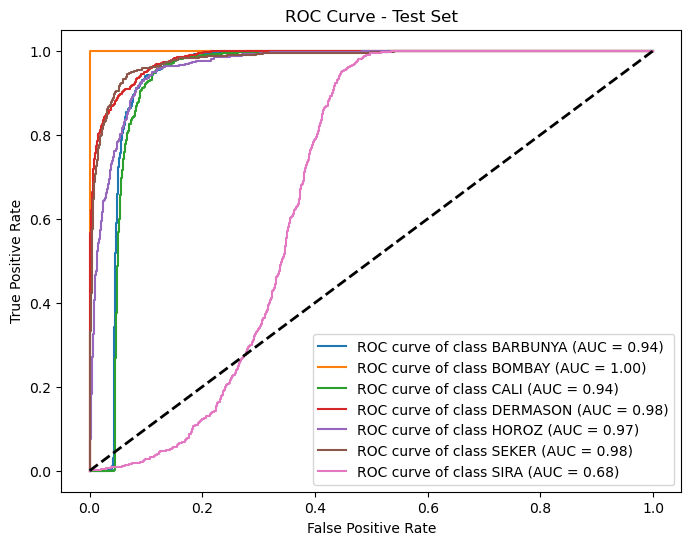

Average AUC (test set): 0.9270
Whole dataset accuracy: 92.52%


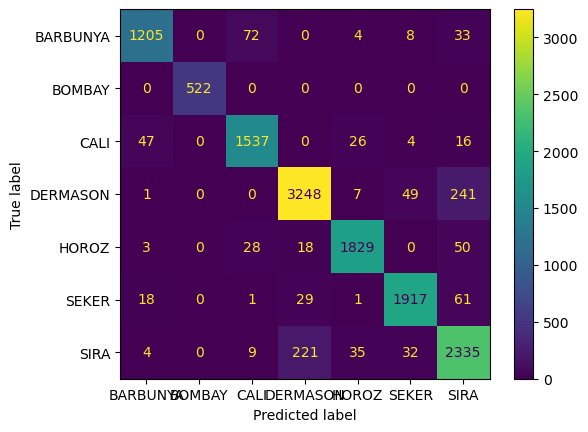

Classification report for the whole dataset:
              precision    recall  f1-score   support

    BARBUNYA       0.94      0.91      0.93      1322
      BOMBAY       1.00      1.00      1.00       522
        CALI       0.93      0.94      0.94      1630
    DERMASON       0.92      0.92      0.92      3546
       HOROZ       0.96      0.95      0.96      1928
       SEKER       0.95      0.95      0.95      2027
        SIRA       0.85      0.89      0.87      2636

    accuracy                           0.93     13611
   macro avg       0.94      0.94      0.94     13611
weighted avg       0.93      0.93      0.93     13611



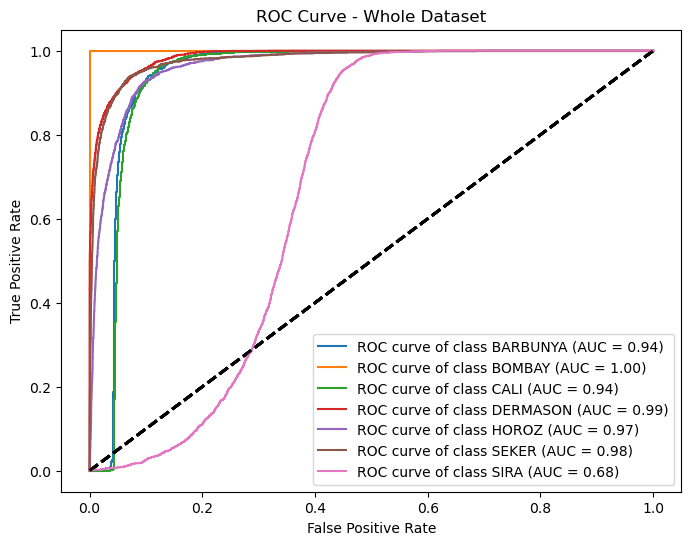

Average AUC (whole dataset): 0.9272


C:\Users\angel\AppData\Local\Temp\ipykernel_23080\3158808785.py:181: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.get_cmap('tab10', len(classes)))
C:\Users\angel\AppData\Local\Temp\ipykernel_23080\3158808785.py:182: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.get_cmap('tab10', len(classes)), edgecolor='k', s=20)


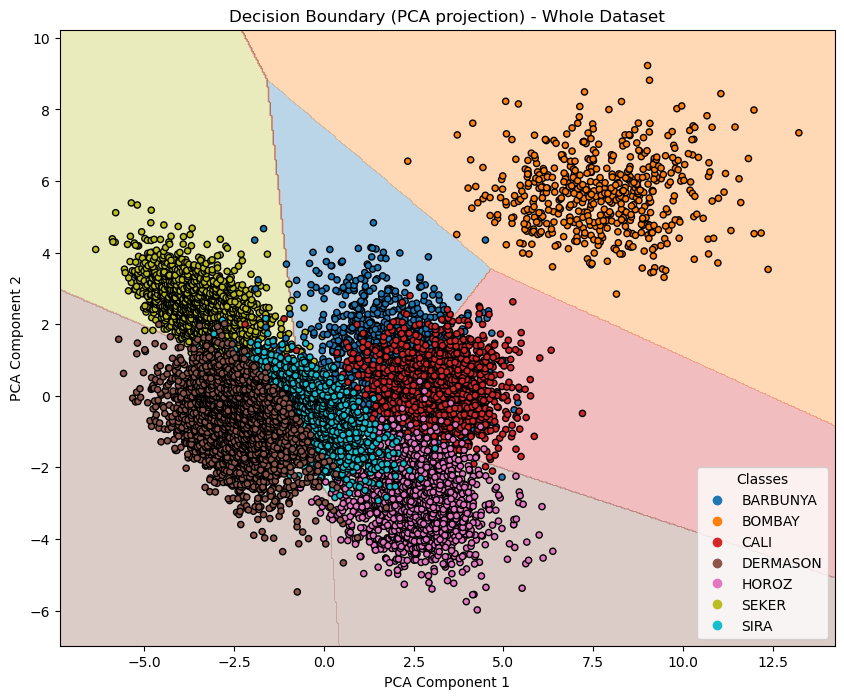

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA

#load and preprocess the data
data = pd.read_csv("Dry_Bean_Dataset.csv")
#features
X = data.iloc[:, :-1].values  
#targets
y = data.iloc[:, -1].values 

#normalize features
X = (X - X.mean(axis=0)) / X.std(axis=0)

#convert labels to integers
classes = np.unique(y)
y = np.array([np.where(classes == label)[0][0] for label in y])

#split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#define parameter grid for GridSearchCV
param_grid = {'C': [1/0.01, 1/0.1, 1/0.5],'max_iter': [1000, 3000, 5000],'solver': ['lbfgs'],'multi_class': ['multinomial']}# C relates to learning rate

#logistic regression with GridSearchCV
logreg = LogisticRegression()
grid = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best hyperparameters found by GridSearchCV:")
print(grid.best_params_)

#evaluate the model in train set
y_pred = grid.predict(X_train)
print("Train set accuracy: {:.2f}%".format(grid.score(X_train, y_train) * 100))
#plot confusion matrix
cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.show()
print("Classification report for train set:")
print(classification_report(y_train, y_pred, target_names=classes))
# Binarize the output for ROC curve (one-vs-rest)
y_train_bin = label_binarize(y_train, classes=range(len(classes)))
y_score = grid.decision_function(X_train)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_train_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {classes[i]} (AUC = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Train Set')
plt.legend(loc="lower right")
plt.show()

# Calculate and print average AUC
average_auc = np.mean(list(roc_auc.values())[:-1])  # exclude 'micro'
print(f'Average AUC (train set): {average_auc:.4f}')

#evaluate the model in test set
y_pred = grid.predict(X_test)
print("Test set accuracy: {:.2f}%".format(grid.score(X_test, y_test) * 100))
#plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.show()
print("Classification report for test set:")
print(classification_report(y_test, y_pred, target_names=classes))
# Binarize the output for ROC curve (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=range(len(classes)))
y_score = grid.decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {classes[i]} (AUC = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend(loc="lower right")
plt.show()

# Calculate and print average AUC
average_auc = np.mean(list(roc_auc.values())[:-1])  # exclude 'micro'
print(f'Average AUC (test set): {average_auc:.4f}')


#evaluate the model in the whole dataset
y_pred = grid.predict(X)
print("Whole dataset accuracy: {:.2f}%".format(grid.score(X, y) * 100))
#plot confusion matrix
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.show()
print("Classification report for the whole dataset:")
print(classification_report(y, y_pred, target_names=classes))
# Binarize the output for ROC curve (one-vs-rest)
y_bin = label_binarize(y, classes=range(len(classes)))
y_score = grid.decision_function(X)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {classes[i]} (AUC = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Whole Dataset')
plt.legend(loc="lower right")
plt.show()

# Calculate and print average AUC
average_auc = np.mean(list(roc_auc.values())[:-1])  # exclude 'micro'
print(f'Average AUC (whole dataset): {average_auc:.4f}')

# Reduce features to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Fit logistic regression on PCA-reduced data for visualization
logreg_vis = LogisticRegression(
    C=grid.best_params_['C'],
    max_iter=grid.best_params_['max_iter'],
    solver=grid.best_params_['solver'],
    multi_class=grid.best_params_['multi_class']
)
logreg_vis.fit(X_pca, y)

# Create a mesh grid for plotting decision boundaries
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
Z = logreg_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.get_cmap('tab10', len(classes)))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.get_cmap('tab10', len(classes)), edgecolor='k', s=20)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Decision Boundary (PCA projection) - Whole Dataset')

# 添加图例
handles, _ = scatter.legend_elements(prop="colors")
plt.legend(handles, classes, title="Classes", loc="best")

plt.show()

